In [1]:
_LOAD_MODELS = false
_SAVE_MODELS = true;

In [2]:
import Pkg; Pkg.activate(joinpath(@__DIR__, "..")); Pkg.instantiate()

  Activating project at `~/Github/floating_rate`
Precompiling project...
  ✓ LTBonds
  1 dependency successfully precompiled in 8 seconds (217 already precompiled)


In [3]:
using Revise
using LTBonds
using Random 
using PrettyTables
using Plots
using Serialization

In [4]:
benchmark_parameters =  let
    R = 1.01
    β = 0.9540232420
    pref = Preferences(β = β, u = make_CRRA(ra = 2))
    y = discretize(YProcess(n = 50, ρ = 0.948503, std = 0.027092, μ = 0.0, span = 3.0, tails = false))
    m = MTruncatedNormal(; std = 0.01, span = 2.0, quadN = 100)
    penalty = DefCosts(pen1 = -0.1881927550, pen2 = 0.2455843389, quadratic = true, reentry = 0.0385)
    η=0.1

    (R=R, pref=pref,  y=y, m=m, penalty=penalty, η=η )
end;

In [5]:
if _LOAD_MODELS
    models = deserialize(joinpath(@__DIR__, "..", "output", "tmpcal1.dat"))
else 
    models = let
        R, pref, y, m, penalty, η = benchmark_parameters
        N = 350

        bondLT = Bond(n = N, min = 0.0, max = 1.5, κ = R - 1, λ = 0.05)  
        bondST = Bond(n = N, min = 0.0, max = 1.5, κ = R - 1, λ = 1.0)  
        bondperp = Bond(n = N, min = 0.0, max = 1.5, κ = R - 1, λ = 0.0) 
        
        bondFR = FloatingRateBond(;n = N, min = 0.0, max = 1.5, λ = 0.05, κbar = 0.05) 
        bondFRlowκ = FloatingRateBond(;n = N, min = 0.0, max = 1.5, λ = 0.05, κbar = 0.015) 
        bondFRperp = FloatingRateBond(; n = N, min = 0.0, max = 1.5, λ = 0.0, κbar = 0.05) 
        bondFRST = FloatingRateBond(n = N, min = 0.0, max = 1.5, λ = 1.0, κbar = 0.05)
   
        bondFRκbar1 = FloatingRateBond(n = N, min = 0.0, max = 1.5, λ = 0.05, κbar = 1.0)

        # EG models

        egperp = LTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondperp, 
            def_costs = penalty, 
            R = R,
        )

        egST = LTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondST, 
            def_costs = penalty, 
            R = R,
        )

        egLT = LTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondLT, 
            def_costs = penalty, 
            R = R,
        )

        frEG = LTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondFR, 
            def_costs = penalty, 
            R = R
        )

        frEGST = LTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondFRST, 
            def_costs = penalty, 
            R = R
        )   

        frEGperp = LTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondFRperp, 
            def_costs = penalty, 
            R = R
        )

        frEGκbar1 = LTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondFRκbar1, 
            def_costs = penalty, 
            R = R
        )

        # CK models 

        ckST = CKLTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondST, 
            def_costs = penalty, 
            R = R,
            η = η
        )

        ckLT = CKLTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondLT, 
            def_costs = penalty, 
            R = R,
            η = η
        )

        fr = CKLTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondFR, 
            def_costs = penalty, 
            R = R,
            η = η
        )   

        frlowκ = CKLTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondFRlowκ, 
            def_costs = penalty, 
            R = R,
            η = η
        )   

        frperp = CKLTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondFRperp, 
            def_costs = penalty, 
            R = R,
            η = η
        )   

        frκbar1 = CKLTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondFRκbar1, 
            def_costs = penalty, 
            R = R,
            η = η
        )   

        models = (; egLT, egST,  egperp, ckLT, ckST, fr, frlowκ, frperp, frEG, frEGperp, frEGST, frEGκbar1, frκbar1)
        map(generate_workspace, models)
    end
    
    @time foreach(models) do m 
        @time solve!(m, print_every = 100, max_iters = 5_000)
    end 
end;

1: (v = 1.503244195357336, q = 0.580987691900618, vD = 0.5336647908767098)
101: (v = 0.0044847070822982005, q = 0.025068799461811286, vD = 0.002272549171188132)
201: (v = 0.00017933770320155418, q = 0.0008063805687396064, vD = 0.00011157254404636774)
301: (v = 5.136731793697891e-6, q = 1.8853220131509474e-5, vD = 3.5104569775512573e-6)
401: (v = 1.4380356816445783e-7, q = 5.130103776229689e-7, vD = 9.968788461378608e-8)
501: (v = 3.964135686373993e-9, q = 1.4057205510731308e-8, vD = 2.7564261984025507e-9)
601: (v = 1.0891554325098696e-10, q = 3.8567204985184844e-10, vD = 7.578648819617229e-11)
639: (v = 2.7782220968219917e-11, q = 9.829259628446607e-11, vD = 1.9333867840032326e-11)
Converged.
 52.587388 seconds (286.63 k allocations: 16.829 MiB, 0.29% compilation time)
1: (v = 1.503244195357336, q = 0.5809876919006187, vD = 0.5336647908767098)
101: (v = 0.0040565929697322645, q = 0.02768189066904614, vD = 0.001677512070976661)
201: (v = 0.00015041611272437194, q = 0.0006756621768095883

301: (v = 8.453168316435722e-6, κ = 4.218202902972479e-6, q = 2.8079441862449706e-5, vD = 3.560304595140451e-6)
401: (v = 2.0704750589572996e-6, κ = 6.609339060492658e-7, q = 5.641267747769074e-6, vD = 1.0570784816366086e-6)
501: (v = 4.62408660695246e-7, κ = 2.834574059917827e-7, q = 1.3944054251258109e-6, vD = 1.7626447146312785e-7)
601: (v = 9.416983104415522e-8, κ = 4.574658474254534e-8, q = 2.383793143989621e-7, vD = 1.1497572671714806e-8)
701: (v = 1.2932531490150723e-8, κ = 1.9773875870043867e-9, q = 2.686233646631564e-8, vD = 5.435822458821349e-9)
801: (v = 2.2141719568935514e-9, κ = 1.0932439398203542e-9, q = 6.893651760542241e-9, vD = 1.096946533607479e-9)
901: (v = 5.507629907697265e-10, κ = 3.1314484338906823e-10, q = 1.4819190874426624e-9, vD = 1.5945644804560288e-10)
1001: (v = 8.79580852597428e-11, κ = 3.879119248040297e-11, q = 2.24404606008477e-10, vD = 2.0044410575792426e-11)
1059: (v = 3.702993467413762e-11, κ = 2.0903945241457222e-11, q = 9.845901871585738e-11, vD =

In [7]:
_SAVE_MODELS && serialize(joinpath(@__DIR__, "..", "output", "tmpcal1.dat"), models);

In [8]:
big_T = 20_000 
big_N = 1_000
rng = Random.seed!(1234)

TaskLocalRNG()

In [9]:
shocks, paths = create_shocks_paths(models.fr, big_T, big_N; rng);  # use the same draws. Make sure we use a CK model.

In [10]:
computed_moments = map(models) do (m) 
    simulation!(paths, shocks, m; n = big_T, trim = 1000, trim_def = 20)
    moments(paths, m)
end;

In [11]:
pretty_table(
    collect(map(m -> pairs(m), computed_moments)),
    row_names = collect(keys(computed_moments)), 
    backend = Val(:html)
)

,mean_bp_y,mean_mv_y,mean_spread,std_spread,mean_κ,max_spread,std_κ,max_κ,std_c_y,cor_tb_y,cor_r_y,cor_r_b_y,cor_r_tb,def_rate,run_share
egLT,0.936006,0.722762,0.079815,0.0443124,0.01,0.672125,1.73472e-18,0.01,1.10502,-0.390322,-0.647562,-0.0270719,0.728249,0.0671258,0.0
egST,0.820555,0.820056,0.00262366,0.00384158,0.01,0.0371682,1.73472e-18,0.01,1.13303,-0.223377,-0.445061,-0.220491,0.852055,0.00250254,0.0
egperp,1.47423,0.877381,0.0299781,0.0198035,0.01,5.6524,1.73472e-18,0.01,1.00938,-0.901432,-0.597637,0.617644,0.562415,0.0270345,0.0
ckLT,0.9359,0.722699,0.0798032,0.0442803,0.01,0.67329,3.46945e-18,0.01,1.10508,-0.39037,-0.647866,-0.0278751,0.728379,0.0671001,0.00255128
ckST,0.375184,0.374992,0.00227121,0.00254372,0.01,0.0340902,1.73472e-18,0.01,1.0546,-0.187089,-0.665001,-0.493129,0.685826,0.00215055,1.0
fr,0.819595,0.818935,0.00289379,0.00631784,0.0106485,0.839769,0.00105496,0.05,1.13589,-0.223771,-0.268634,-0.119333,0.547131,0.00274272,0.0423749
frlowκ,0.871173,0.775656,0.0376519,0.0287286,0.0111077,0.527473,0.00172225,0.015,1.1185,-0.304104,-0.435756,0.0348569,0.56534,0.032932,0.00285704
frperp,1.03356,0.759363,0.142028,450.984,0.0107973,1.79107e6,0.00341223,0.05,1.15226,-0.214724,-0.00036697,0.000383213,3.01915e-5,0.0171453,0.00462191
frEG,0.822411,0.821814,0.0028384,0.00612604,0.0106401,0.878642,0.00103488,0.05,1.13502,-0.223517,-0.270841,-0.119742,0.55536,0.00267636,0.0
frEGperp,1.03172,0.763601,0.125575,389.739,0.0107711,1.55186e6,0.00334575,0.05,1.15017,-0.213756,-0.000365606,0.000391173,3.13791e-5,0.0166217,0.0


# Plots 

In [12]:
#set linewidth for plots:
lw = 2
ms = 3
msdiamond = 5
default(size = (600, 400), xtickfontsize = 12, ytickfontsize = 12, yguidefontsize = 14, xguidefontsize = 14)

In [13]:
###Value at zero debt plots###
#Global variables rock!
ygrid = get_y_grid(first(models))
nY = length(ygrid)
midY = nY ÷ 2
β = first(models).model.preferences.β;

In [14]:
_get_frontier_y_state(::AbstractFixedRateBond, yi, lag_y) = (yi, )
_get_frontier_y_state(::AbstractFloatingRateBond, yi, lag_y) = (yi, lag_y)
_get_frontier_κ(bond::AbstractFixedRateBond, _, _, _) = get_κ(bond)
_get_frontier_κ(::AbstractFloatingRateBond, m, bi, lag_y) = m.current.κ[bi, lag_y]
_get_frontier_mv(bond::AbstractFixedRateBond, q, b, _) = find_bond_return(bond; q) * b
_get_frontier_mv(bond::AbstractFloatingRateBond, q, b, κ) = find_bond_return(bond; q, κ) * b
get_frontier(m, yi; kwargs...) = get_frontier(get_bond(m), m, yi; kwargs...)

get_frontier (generic function with 1 method)

In [15]:
function get_frontier(bond, m::LTBonds.WorkSpace, yi; lag_y = midY)
    bgrid = get_b_grid(m)
    λ = get_λ(bond)
    mv = []
    v = []
    y_state = _get_frontier_y_state(bond, yi, lag_y)
    for bi=1:length(bgrid)
        default = m.policies.d[bi, y_state...] == m.model.m.m_min
        biprime = get_b_pol(m)[bi, y_state...][end, 1].idx
        q = get_q(m)[biprime, yi]
        κ = _get_frontier_κ(bond, m, bi, lag_y)
        b = get_b_grid(m)[bi]
        push!(mv, (1 - default) * _get_frontier_mv(bond, q, b, κ))
        push!(v, (1 - default) * get_v(m)[bi, y_state...] + default * get_vD(m)[yi])
    end
    return v, mv
end

get_frontier (generic function with 2 methods)

In [16]:
markerevery(series; n = 1) = collect(view(series, 1:n:length(series)))

markerevery (generic function with 1 method)

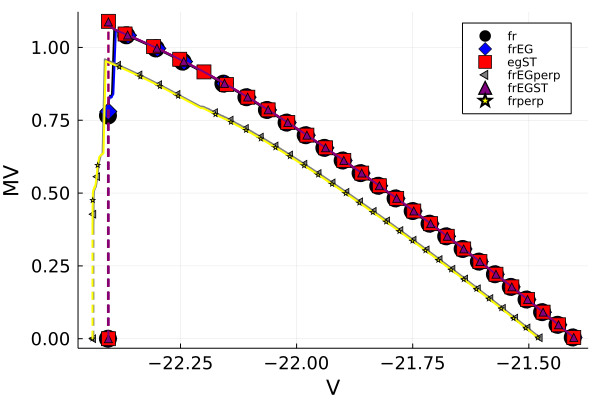

In [30]:
let 
    frontiers = Dict( [key => (m, get_frontier(m, midY)...) for (key, m) in pairs(models)])
    
    f = plot()
    for (m, marker, color, s) in zip(
            [:fr, :frEG, :egST, :frEGperp, :frEGST, :frperp], 
            [:circle, :diamond, :square, :ltriangle, :utriangle, :star], 
            [:black, :blue, :red, :gray, :purple, :yellow],
            [1, 2, 3, 4, 5, 6])
        vD = get_vD(models[m])[midY]
        xx = [x  for x in zip(frontiers[m][2], frontiers[m][3]) if x[1] >= vD && x[2] > 0]

        plot!(f, [x[1] for x in xx], [x[2] for x in xx], 
            line = (lw, color), xlabel = ("V"), ylabel = ("MV"), 
            label = nothing)
        plot!(f, [vD], [0], marker = marker, markercolor = color, markersize = 3/2 * (7 - s) + 1, label = nothing)
        plot!(f, [vD, xx[end][1]], [0, xx[end][2]], ls = :dash, markersize = 3/2 * (7 - s) + 1, 
            line = (lw, color), label = nothing)
        xx_f = markerevery(xx; n = 10)
        scatter!(f, [x[1] for x in xx_f], [x[2] for x in xx_f], 
            markershape = marker, markercolor = color, markersize = 3/2 * (7 - s) + 1,
            label = String(m))
    end 

    f
end 

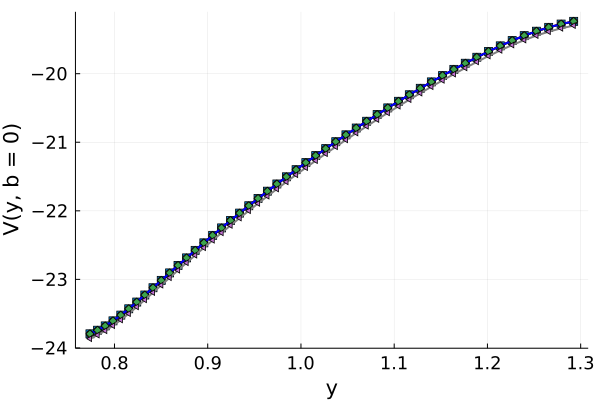

In [18]:
let f = plot()
    plot!(f, ygrid, get_v(models.egST)[1, :] , line = (lw, :red), markershape = :square)
    plot!(f, ygrid, get_v(models.fr)[1, :, midY], line = (lw, :black), legend = false, xlabel = ("y"), ylabel = ("V(y, b = 0)"), markershape = :circle)
    plot!(f, ygrid, get_v(models.frEG)[1, :, midY] , line = (lw, :blue), markershape = :diamond)
    plot!(f, ygrid, get_v(models.frEGperp)[1, :, midY] , line = (lw, :gray), markershape = :ltriangle)
    f
end 

# Multiplicity ?

In [33]:
frEG = let 
    R, pref, y, m, penalty, η = benchmark_parameters
    N = 350

    bondFR = FloatingRateBond(;n = N, min = 0.0, max = 1.5, λ = 0.05, κbar = 1.0) 
    
    extra_model = LTBondModel(
        y = y,
        m = m, 
        preferences = pref, 
        bond = bondFR, 
        def_costs = penalty, 
        R = R
    )

    ws = generate_workspace(extra_model)
    
    @time solve!(ws, print_every = 100, max_iters = 5_000)
    ws
end;

simulation!(paths, shocks, frEG; n = big_T, trim = 1000, trim_def = 20)
moments(paths, frEG)

1: (v = 1.5032441953573397, κ = 0.99, q = 0.5809876919006184, vD = 0.5336647908767098)
101: (v = 0.5940688157285337, κ = 0.8589244761223902, q = 0.8211481306528485, vD = 0.00162299528116705)
201: (v = 0.05914266839188542, κ = 0.2598617946075368, q = 0.14682357777521304, vD = 8.654594854107245e-5)
301: (v = 0.00025212138503860615, κ = 0.0001316958573671645, q = 3.9600822057894725e-5, vD = 2.3453446296173297e-6)
401: (v = 5.831700065073164e-7, κ = 3.6776842526897724e-7, q = 1.5568682121269717e-8, vD = 4.516475371474371e-8)
501: (v = 1.0046100840099825e-8, κ = 6.322780521372806e-9, q = 2.7002522440255916e-10, vD = 7.990017536485539e-10)
601: (v = 1.7206147617798706e-10, κ = 1.0817946538566048e-10, q = 4.6104231543608876e-12, vD = 1.3862688774679555e-11)
615: (v = 9.741185635903093e-11, κ = 6.123834772608916e-11, q = 2.613798066875006e-12, vD = 7.851497230149107e-12)
Converged.
264.146779 seconds (70.73 k allocations: 6.282 MiB)


(mean_bp_y = 0.8199921304148123, mean_mv_y = 0.819992130411816, mean_spread = 0.002619405740058719, std_spread = 0.003840098650123703, mean_κ = 0.010633716009435247, max_spread = 0.03685471866052925, std_κ = 0.0009269871837585017, max_κ = 0.018826331965162924, std_c_y = 1.1330377538862315, cor_tb_y = -0.2232787560128123, cor_r_y = -0.44395689193302446, cor_r_b_y = -0.2285780517958023, cor_r_tb = 0.8502182251670601, def_rate = 0.002497357583579385, run_share = 0.0)

In [43]:
frEG_2 = let 
    R, pref, y, m, penalty, η = benchmark_parameters
    N = 350

    bondFR = FloatingRateBond(;n = N, min = 0.0, max = 1.5, λ = 0.05, κbar = 1.0) 
    
    extra_model = LTBondModel(
        y = y,
        m = m, 
        preferences = pref, 
        bond = bondFR, 
        def_costs = penalty, 
        R = R
    )

    ws = copy_workspace(extra_model, models.frEGST)
    
    @time solve!(ws, print_every = 100, max_iters = 5_000)
    ws
end;

simulation!(paths, shocks, frEG_2; n = big_T, trim = 1000, trim_def = 20)
moments(paths, frEG_2)

1: (v = 0.011665291635132746, κ = 0.95, q = 0.005445688889022804, vD = 8.185452315956354e-12)
101: (v = 1.149423702884178e-7, κ = 8.149968233617244e-8, q = 1.4597748121403242e-8, vD = 2.2712367098165487e-8)
201: (v = 1.2206864852259969e-8, κ = 7.777382071694205e-9, q = 2.877338367568427e-10, vD = 8.301732634663495e-10)
301: (v = 2.275797328366025e-10, κ = 1.4400280967663548e-10, q = 6.100675520315235e-12, vD = 1.6918022538447985e-11)
322: (v = 9.683631674306525e-11, κ = 6.12041528569307e-11, q = 2.6048052603755423e-12, vD = 7.318590178329032e-12)
Converged.
138.609753 seconds (37.45 k allocations: 3.305 MiB)


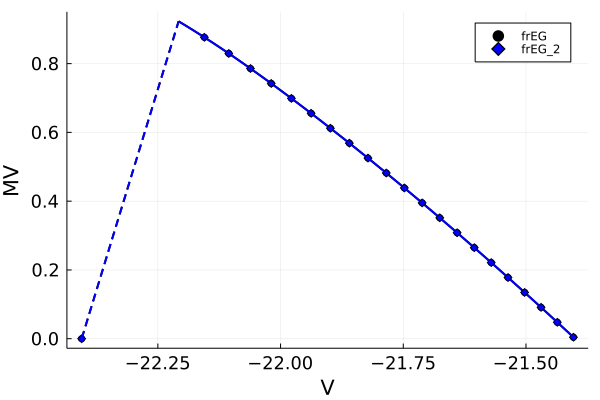

In [48]:
let 
    models = (; frEG, frEG_2)
    
    frontiers = Dict( [key => (m, get_frontier(m, midY)...) for (key, m) in pairs(models)])
    
    f = plot()
    for (m, marker, color) in zip(
            keys(models), 
            [:circle, :diamond, :square, :ltriangle, :utriangle, :star], 
            [:black, :blue, :red, :gray, :purple, :yellow])
        vD = get_vD(models[m])[midY]
        xx = [x  for x in zip(frontiers[m][2], frontiers[m][3]) if x[1] >= vD && x[2] > 0]

        plot!(f, [x[1] for x in xx], [x[2] for x in xx], 
            line = (lw, color), xlabel = ("V"), ylabel = ("MV"), 
            label = nothing)
        plot!(f, [vD], [0], marker = marker, markercolor = color, label = nothing)
        plot!(f, [vD, xx[end][1]], [0, xx[end][2]], ls = :dash,line = (lw, color), label = nothing)
        xx_f = markerevery(xx; n = 10)
        scatter!(f, [x[1] for x in xx_f], [x[2] for x in xx_f], 
            markershape = marker, markercolor = color, label = String(m))
    end 

    f
end 